# Raw Analytics - Acidentes Aéreos

Análise de qualidade dos dados brutos da camada Bronze.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Carregamento


In [2]:
plt.style.use('seaborn-v0_8')
sns.set_theme(context="notebook", style="whitegrid")

df_raw = pd.read_csv('Data Layer/raw/data_raw.csv')
df_raw_temp = df_raw.copy()

FileNotFoundError: [Errno 2] No such file or directory: 'Data Layer/raw/data_raw.csv'

## 2. Dados Faltantes por Coluna


In [ ]:
missing_data = pd.DataFrame({
    'Coluna': df.columns,
    'Nulos': df.isnull().sum().values,
    'Total': df.isnull().sum().values + (df == '').sum().values,
    '%': ((df.isnull().sum().values + (df == '').sum().values) / len(df) * 100).round(2)
})

missing_data = missing_data[missing_data['Total'] > 0].sort_values('Total', ascending=False)
missing_data


Total de registros: 6114
Período: 01/01/2011 11:00 até 31/12/2020 13:24


,Codigo da Ocorrencia,Classificacao da Ocorrencia,Data e Hora da Ocorrencia,Latitude da Ocorrencia,Longitude da Ocorrencia,Cidade da Ocorrencia,UF da Ocorrencia,Aerodromo da Ocorrencia,Total de Recomendacoes,Total de Aeronaves Envolvidas,Ocorrencia na Saida da Pista?,Tipo de Ocorrencia,Matricula da Aeronave,Tipo de Aeronave,Fabricante da Aeronave,Modelo de Aeronave,Aeronave Motor Tipo,Quantidade de Assentos na Aeronave,Ano de Fabricacao da Aeronave,Voo de Origem do Acidente,Voo Destino do Acidente,Fase de Operacao da Aeronave,Nivel de Dano da Aeronave,Total de Fatalidades no Acidente
0,39115,ACIDENTE,07/02/2010 17:40,"-1,34E+11","-4,46E+11",CORRENTINA,BA,SNTY,2,1,NÃO,PANE SECA,PTNQX,AVIÃO,NEIVA INDUSTRIA AERONAUTICA,EMB-711A,PISTÃO,4.0,1979.0,BRIGADEIRO ARARIPE MACEDO,CORRENTINA,DECOLAGEM,SUBSTANCIAL,0
1,39156,INCIDENTE GRAVE,10/01/2010 23:15,"-1,52E+11","-5,94E+11",CASCAVEL,PR,SBCA,2,1,NÃO,FOGO EM VOO,PPPTO,AVIÃO,AEROSPATIALE AND ALENIA,ATR-72-212A,TURBOÉLICE,73.0,2008.0,AFONSO PENA,ADALBERTO MENDES DA SILVA,ARREMETIDA NO AR,LEVE,0
2,39235,ACIDENTE,06/02/2010 17:20,"-1,81E+11","-5,01E+11",ITUMBIARA,GO,****,3,1,NÃO,PERDA DE CONTROLE EM VOO,PTWKN,AVIÃO,CESSNA AIRCRAFT,A188B,PISTÃO,1.0,1976.0,FORA DE AERODROMO,FORA DE AERODROMO,DECOLAGEM,DESTRUÍDA,1


In [ ]:
if len(missing_data) > 0:
    fig, ax = plt.subplots(figsize=(12, 6))
    top_missing = missing_data.head(10)
    colors = sns.color_palette('rocket', n_colors=len(top_missing))
    
    ax.barh(top_missing['Coluna'], top_missing['Total'], color=colors)
    ax.set_xlabel('Valores Faltantes')
    ax.set_title('Top 10 Colunas com Dados Faltantes')
    
    for i, (idx, row) in enumerate(top_missing.iterrows()):
        ax.text(row['Total'], i, f" {row['Total']:,.0f} ({row['%']:.1f}%)", ha='left', va='center')
    
    plt.tight_layout()
    plt.show()
else:
    print("Nenhum valor faltante significativo")


NameError: name 'missing_data' is not defined

## 3. Evolução Temporal de Ocorrências


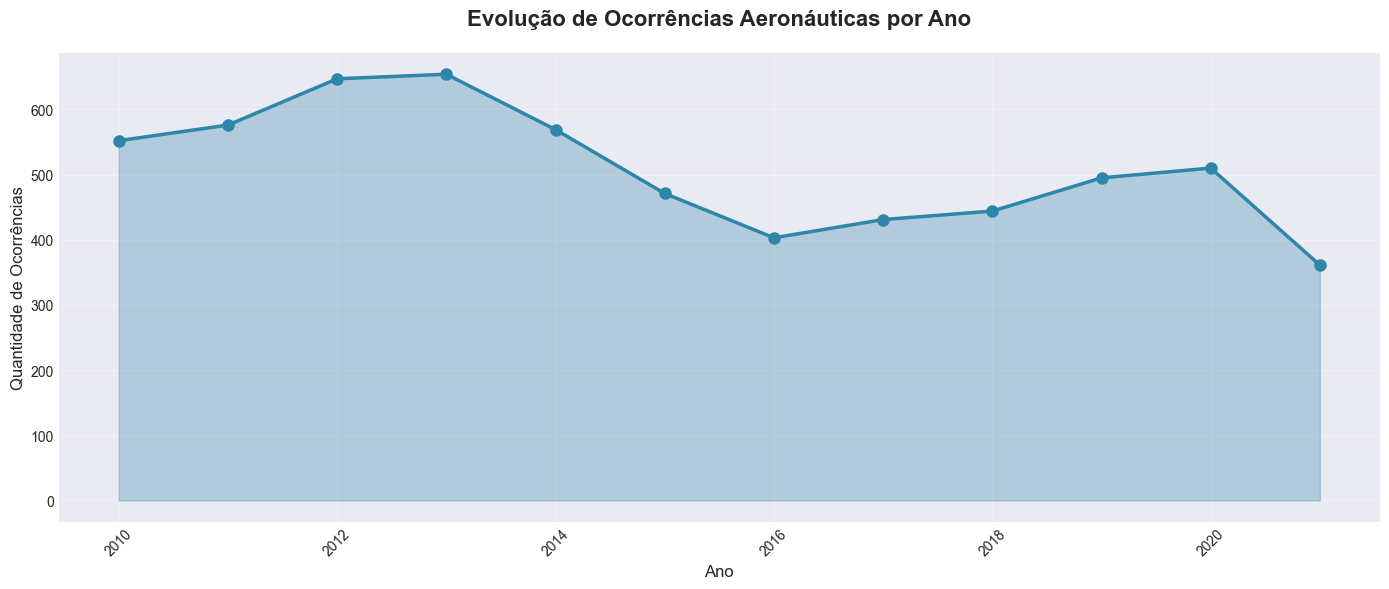

Ano com mais ocorrências: 2013 (654 ocorrências)


In [ ]:
# Preparando dados temporais
df['Data e Hora da Ocorrencia'] = pd.to_datetime(df['Data e Hora da Ocorrencia'], format='%d/%m/%Y %H:%M', errors='coerce')
df['Ano'] = df['Data e Hora da Ocorrencia'].dt.year
ocorrencias_ano = df.groupby('Ano').size().reset_index(name='Quantidade')
ocorrencias_ano = ocorrencias_ano[ocorrencias_ano['Ano'].notna()]

# Gráfico
plt.figure(figsize=(14, 6))
plt.plot(ocorrencias_ano['Ano'], ocorrencias_ano['Quantidade'], marker='o', linewidth=2.5, markersize=8, color='#2E86AB')
plt.fill_between(ocorrencias_ano['Ano'], ocorrencias_ano['Quantidade'], alpha=0.3, color='#2E86AB')
plt.title('Evolução de Ocorrências Aeronáuticas por Ano', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Ano', fontsize=12)
plt.ylabel('Quantidade de Ocorrências', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"Ano com mais ocorrências: {ocorrencias_ano.loc[ocorrencias_ano['Quantidade'].idxmax(), 'Ano']:.0f} ({ocorrencias_ano['Quantidade'].max()} ocorrências)")


## 3. Classificação das Ocorrências


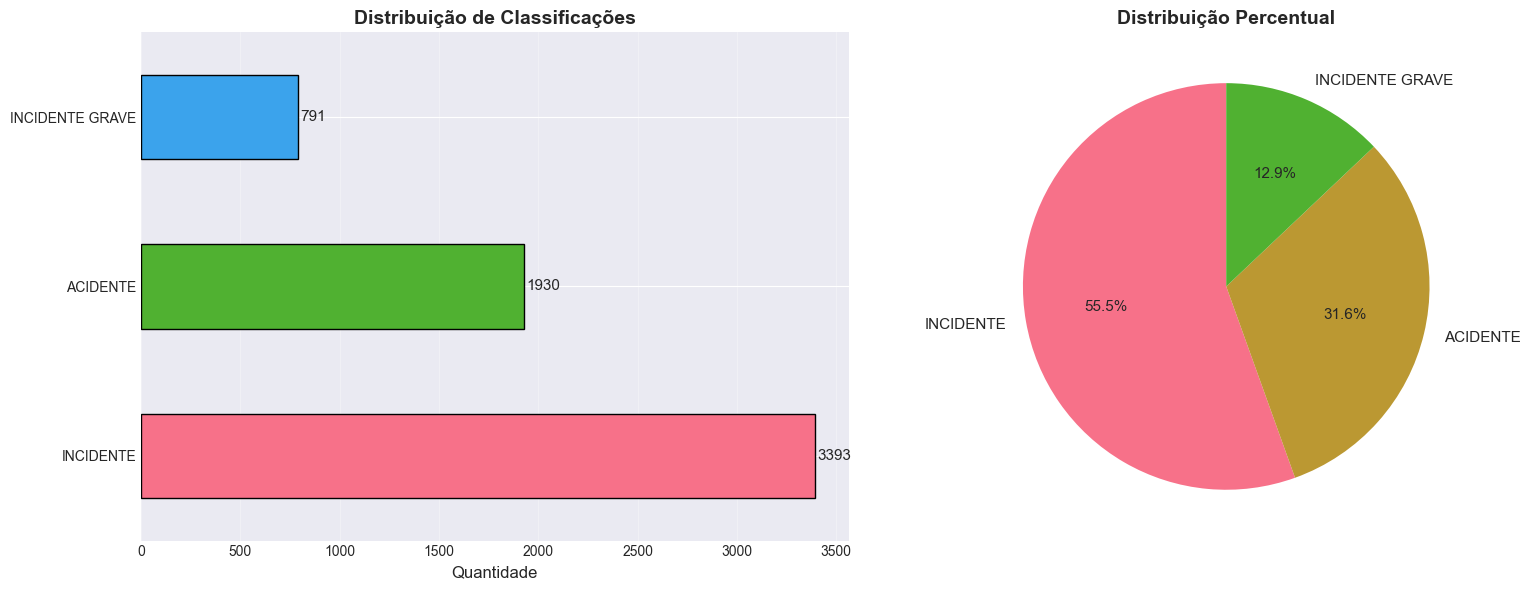

Classificacao da Ocorrencia 
INCIDENTE          3393
ACIDENTE           1930
INCIDENTE GRAVE     791
Name: count, dtype: int64


In [ ]:
col_class = 'Classificacao da Ocorrencia ' if 'Classificacao da Ocorrencia ' in df.columns else 'Classificacao da Ocorrencia'
classificacoes = df[col_class].value_counts()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Barras
classificacoes.plot(kind='barh', ax=ax1, color=sns.color_palette("husl", len(classificacoes)), edgecolor='black')
ax1.set_title('Distribuição de Classificações', fontsize=14, fontweight='bold')
ax1.set_xlabel('Quantidade', fontsize=12)
ax1.set_ylabel('')
ax1.grid(axis='x', alpha=0.3)
for i, v in enumerate(classificacoes.values):
    ax1.text(v + 10, i, str(v), va='center', fontsize=11)

# Pizza
classificacoes.plot(kind='pie', ax=ax2, autopct='%1.1f%%', startangle=90, textprops={'fontsize': 11})
ax2.set_title('Distribuição Percentual', fontsize=14, fontweight='bold')
ax2.set_ylabel('')

plt.tight_layout()
plt.show()

print(classificacoes)


## 4. Ocorrências por Estado


C:\Users\lucas\AppData\Local\Temp\ipykernel_11008\2132478389.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=ocorrencias_uf.values, y=ocorrencias_uf.index, orient='h', palette='viridis')


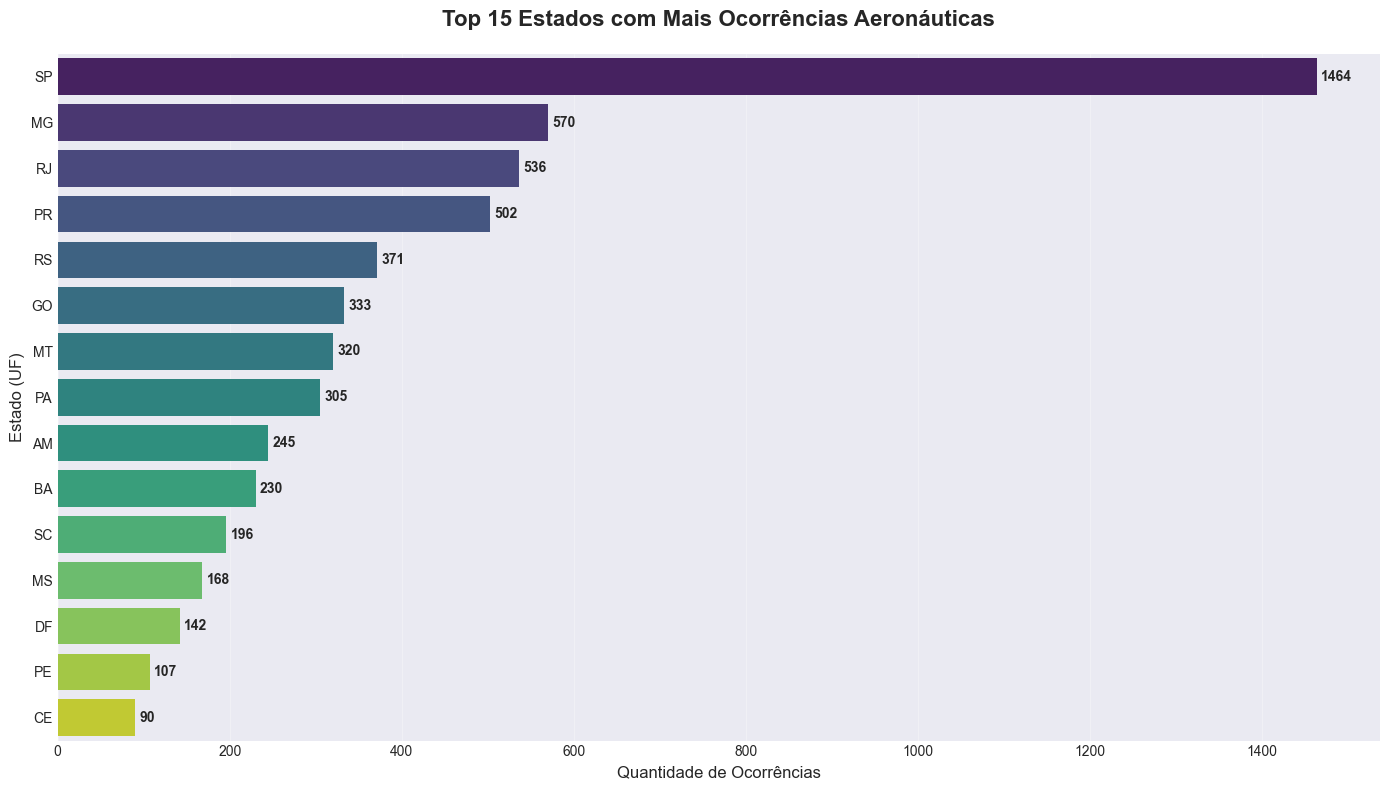

Estado com mais ocorrências: SP (1464 ocorrências)


In [ ]:
ocorrencias_uf = df['UF da Ocorrencia'].value_counts().head(15)

plt.figure(figsize=(14, 8))
ax = sns.barplot(x=ocorrencias_uf.values, y=ocorrencias_uf.index, orient='h', palette='viridis')

for i, v in enumerate(ocorrencias_uf.values):
    ax.text(v + 5, i, str(v), va='center', fontsize=10, fontweight='bold')

plt.title('Top 15 Estados com Mais Ocorrências Aeronáuticas', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Quantidade de Ocorrências', fontsize=12)
plt.ylabel('Estado (UF)', fontsize=12)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Estado com mais ocorrências: {ocorrencias_uf.index[0]} ({ocorrencias_uf.values[0]} ocorrências)")


## 5. Tipos de Ocorrências Mais Frequentes


C:\Users\lucas\AppData\Local\Temp\ipykernel_11008\3796997615.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=tipos_ocorrencia.values, y=tipos_ocorrencia.index, orient='h', palette='rocket', edgecolor='black')


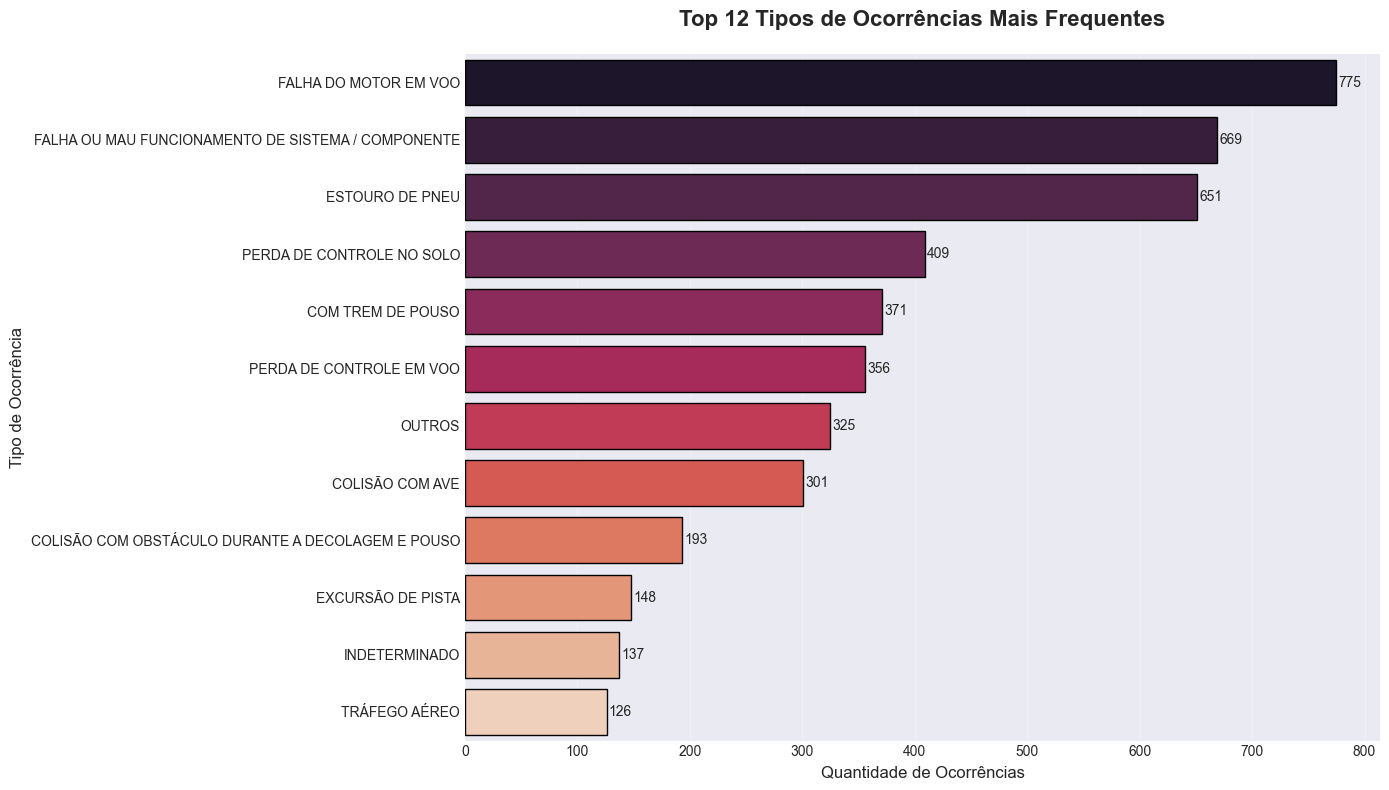

Tipo mais comum: FALHA DO MOTOR EM VOO (775 ocorrências - 12.7% do total)


In [ ]:
tipos_ocorrencia = df['Tipo de Ocorrencia'].value_counts().head(12)

plt.figure(figsize=(14, 8))
ax = sns.barplot(x=tipos_ocorrencia.values, y=tipos_ocorrencia.index, orient='h', palette='rocket', edgecolor='black')

for i, v in enumerate(tipos_ocorrencia.values):
    ax.text(v + 2, i, str(v), va='center', fontsize=10)

plt.title('Top 12 Tipos de Ocorrências Mais Frequentes', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Quantidade de Ocorrências', fontsize=12)
plt.ylabel('Tipo de Ocorrência', fontsize=12)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Tipo mais comum: {tipos_ocorrencia.index[0]} ({tipos_ocorrencia.values[0]} ocorrências - {tipos_ocorrencia.values[0]/len(df)*100:.1f}% do total)")


## 6. Análise de Fatalidades


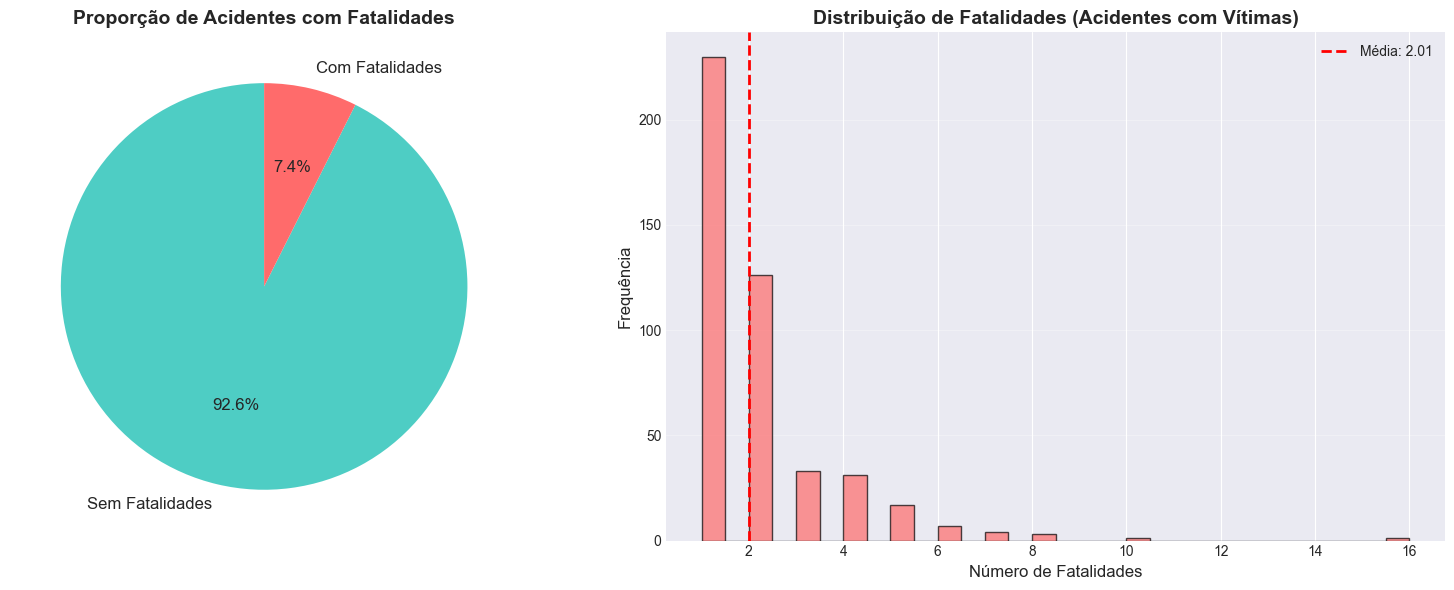

Total de acidentes: 6114
Acidentes com fatalidades: 453 (7.41%)
Acidentes sem fatalidades: 5661 (92.59%)
Média de fatalidades (quando há vítimas): 2.01
Máximo de fatalidades em um acidente: 16


In [ ]:
df['Total de Fatalidades no Acidente'] = pd.to_numeric(df['Total de Fatalidades no Acidente'], errors='coerce')

com_fatalidades = (df['Total de Fatalidades no Acidente'] > 0).sum()
sem_fatalidades = (df['Total de Fatalidades no Acidente'] == 0).sum()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Pizza
axes[0].pie([sem_fatalidades, com_fatalidades], labels=['Sem Fatalidades', 'Com Fatalidades'],
           autopct='%1.1f%%', startangle=90, colors=['#4ECDC4', '#FF6B6B'], textprops={'fontsize': 12})
axes[0].set_title('Proporção de Acidentes com Fatalidades', fontsize=14, fontweight='bold')

# Histograma
fatalidades_validas = df[df['Total de Fatalidades no Acidente'] > 0]['Total de Fatalidades no Acidente']
axes[1].hist(fatalidades_validas, bins=30, color='#FF6B6B', edgecolor='black', alpha=0.7)
axes[1].set_title('Distribuição de Fatalidades (Acidentes com Vítimas)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Número de Fatalidades', fontsize=12)
axes[1].set_ylabel('Frequência', fontsize=12)
axes[1].grid(axis='y', alpha=0.3)
axes[1].axvline(fatalidades_validas.mean(), color='red', linestyle='--', linewidth=2, 
                label=f'Média: {fatalidades_validas.mean():.2f}')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"Total de acidentes: {len(df)}")
print(f"Acidentes com fatalidades: {com_fatalidades} ({com_fatalidades/len(df)*100:.2f}%)")
print(f"Acidentes sem fatalidades: {sem_fatalidades} ({sem_fatalidades/len(df)*100:.2f}%)")
print(f"Média de fatalidades (quando há vítimas): {fatalidades_validas.mean():.2f}")
print(f"Máximo de fatalidades em um acidente: {df['Total de Fatalidades no Acidente'].max():.0f}")


## 7. Fases de Operação com Mais Ocorrências


C:\Users\lucas\AppData\Local\Temp\ipykernel_11008\3306242823.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=fases.values, y=fases.index, orient='h', palette='mako', edgecolor='black')


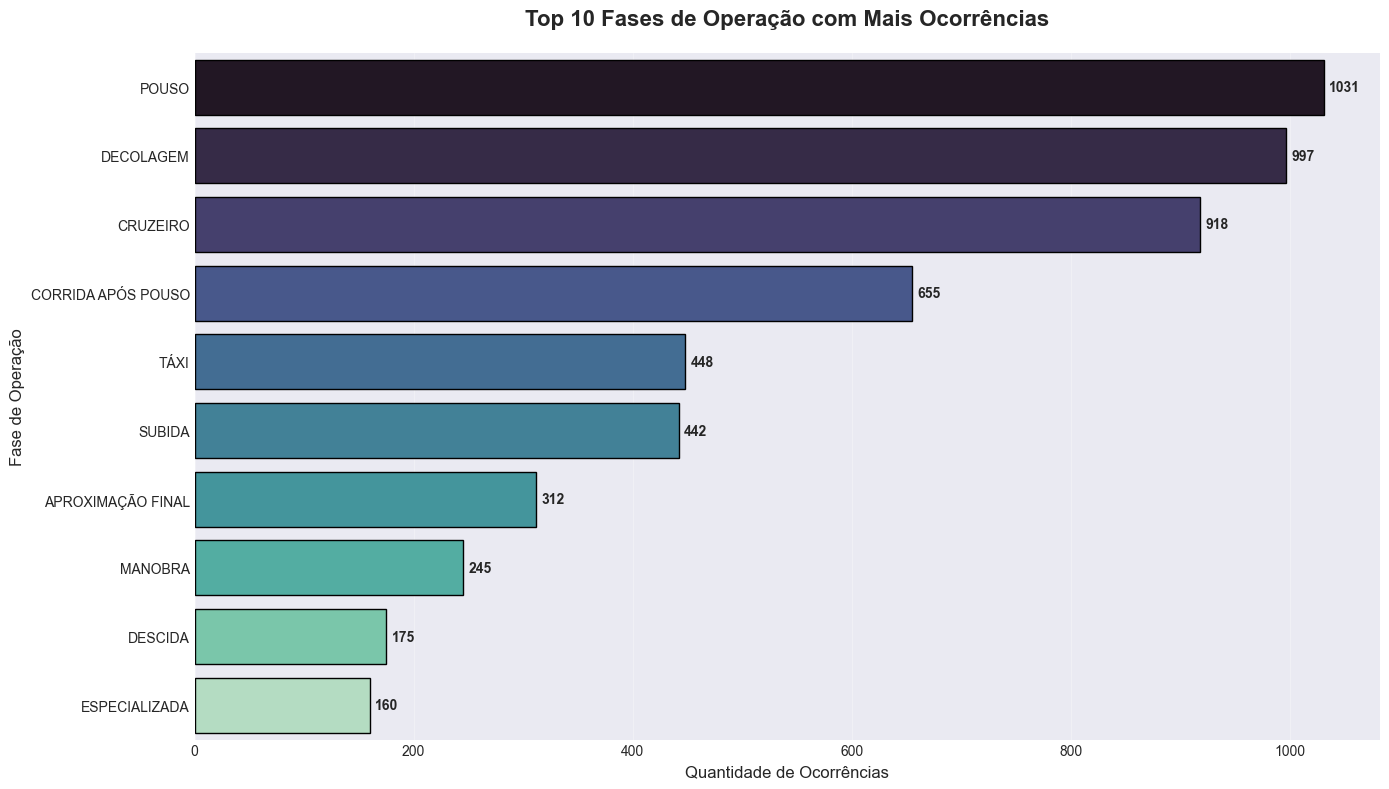

Fase mais crítica: POUSO (1031 ocorrências - 16.9% do total)


In [ ]:
fases = df['Fase de Operacao da Aeronave'].value_counts().head(10)

plt.figure(figsize=(14, 8))
ax = sns.barplot(x=fases.values, y=fases.index, orient='h', palette='mako', edgecolor='black')

for i, v in enumerate(fases.values):
    ax.text(v + 5, i, str(v), va='center', fontsize=10, fontweight='bold')

plt.title('Top 10 Fases de Operação com Mais Ocorrências', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Quantidade de Ocorrências', fontsize=12)
plt.ylabel('Fase de Operação', fontsize=12)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Fase mais crítica: {fases.index[0]} ({fases.values[0]} ocorrências - {fases.values[0]/len(df)*100:.1f}% do total)")


## 8. Tipos de Aeronaves Envolvidas


C:\Users\lucas\AppData\Local\Temp\ipykernel_11008\820001878.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=tipos_aeronave.values, y=tipos_aeronave.index, orient='h', palette='viridis', edgecolor='black')


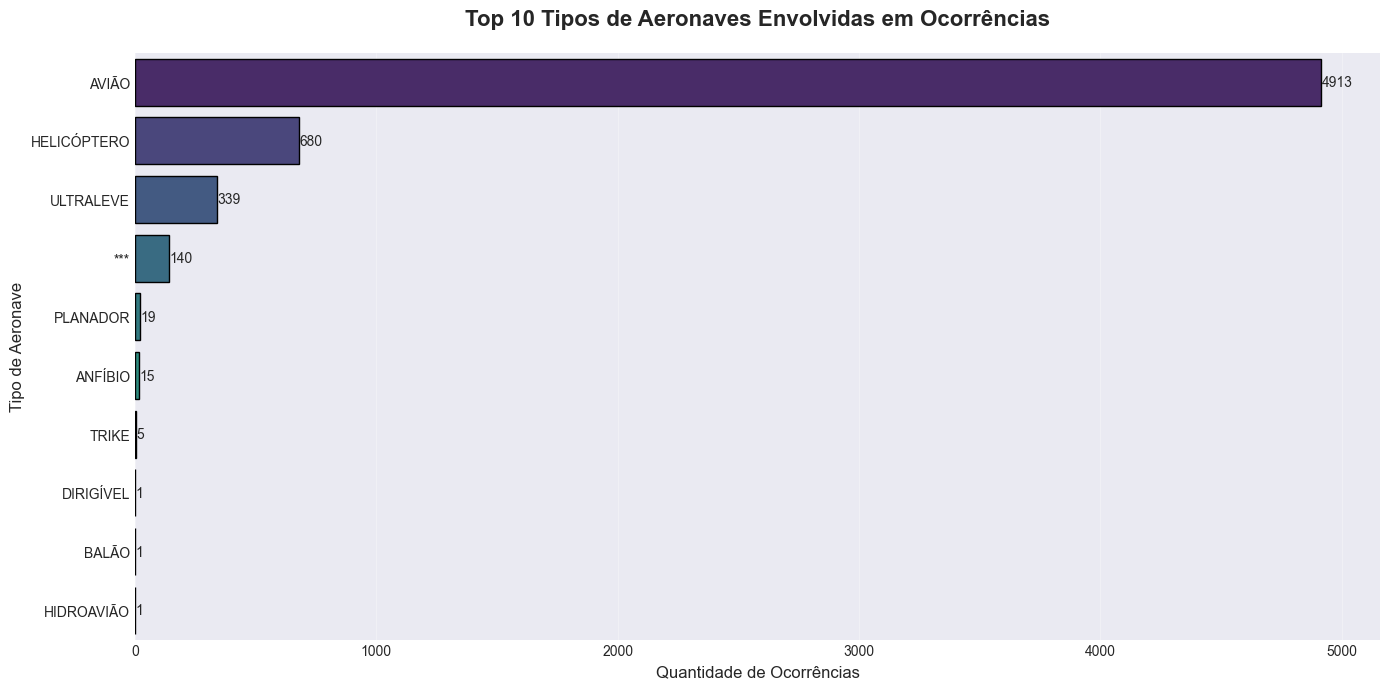

Tipo mais envolvido: AVIÃO (4913 ocorrências)


In [ ]:
tipos_aeronave = df['Tipo de Aeronave'].value_counts().head(10)

plt.figure(figsize=(14, 7))
ax = sns.barplot(x=tipos_aeronave.values, y=tipos_aeronave.index, orient='h', palette='viridis', edgecolor='black')

for i, v in enumerate(tipos_aeronave.values):
    ax.text(v + 3, i, str(v), va='center', fontsize=10)

plt.title('Top 10 Tipos de Aeronaves Envolvidas em Ocorrências', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Quantidade de Ocorrências', fontsize=12)
plt.ylabel('Tipo de Aeronave', fontsize=12)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Tipo mais envolvido: {tipos_aeronave.index[0]} ({tipos_aeronave.values[0]} ocorrências)")


## 9. Fase de Operação vs Nível de Dano


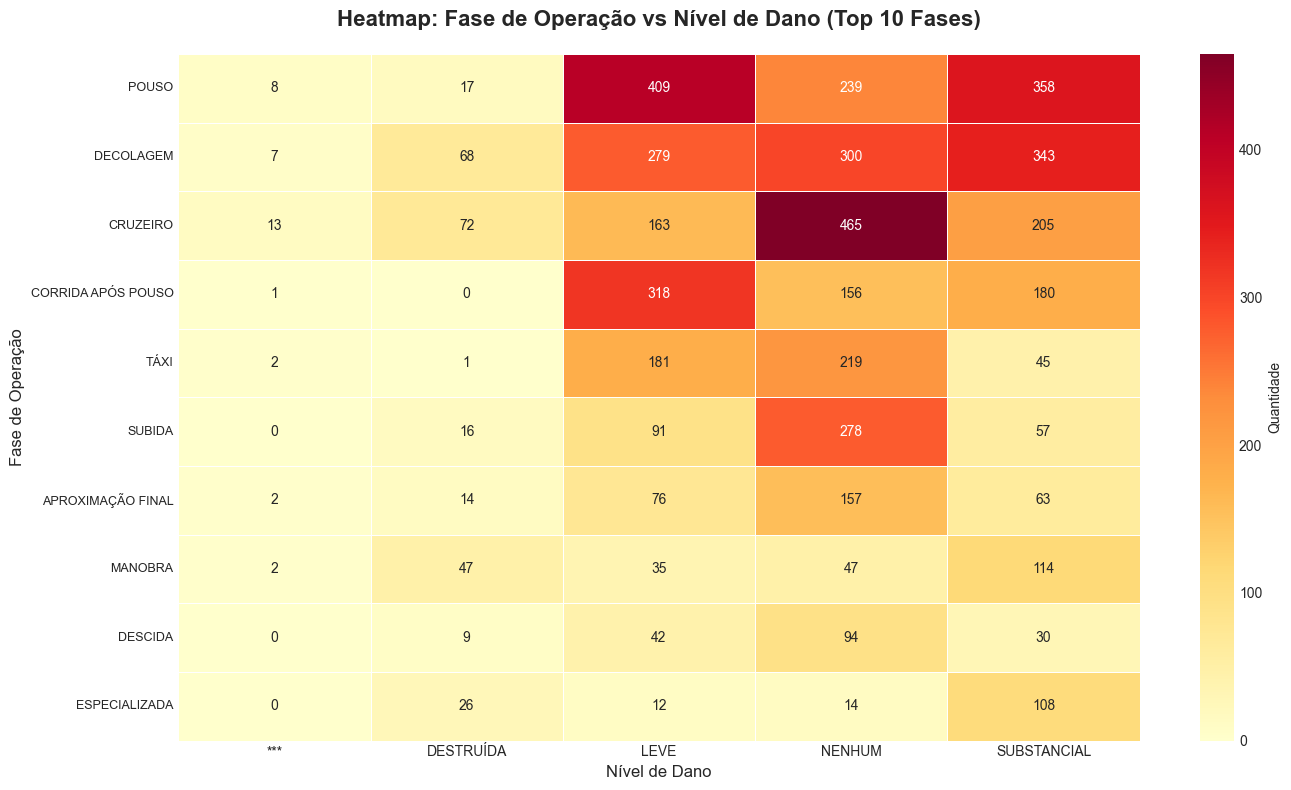

Células mais escuras indicam maior concentração de ocorrências.


In [ ]:
fase_dano = df.groupby(['Fase de Operacao da Aeronave', 'Nivel de Dano da Aeronave']).size().reset_index(name='Quantidade')
pivot_fase_dano = fase_dano.pivot(index='Fase de Operacao da Aeronave', columns='Nivel de Dano da Aeronave', values='Quantidade').fillna(0)

# Top 10 fases
pivot_fase_dano['Total'] = pivot_fase_dano.sum(axis=1)
pivot_fase_dano = pivot_fase_dano.sort_values('Total', ascending=False).head(10).drop('Total', axis=1)

plt.figure(figsize=(14, 8))
sns.heatmap(pivot_fase_dano, annot=True, fmt='.0f', cmap='YlOrRd', cbar_kws={'label': 'Quantidade'}, linewidths=0.5)
plt.title('Heatmap: Fase de Operação vs Nível de Dano (Top 10 Fases)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Nível de Dano', fontsize=12)
plt.ylabel('Fase de Operação', fontsize=12)
plt.tick_params(axis='y', labelsize=9)
plt.tight_layout()
plt.show()

print("Células mais escuras indicam maior concentração de ocorrências.")


## 10. Relação Idade da Aeronave vs Fatalidades


In [ ]:
df['Ano de Fabricacao da Aeronave'] = pd.to_numeric(df['Ano de Fabricacao da Aeronave'], errors='coerce')
df_aeronave = df[(df['Ano de Fabricacao da Aeronave'].notna()) & 
                 (df['Ano de Fabricacao da Aeronave'] > 1900) &
                 (df['Ano de Fabricacao da Aeronave'] <= 2024) &
                 (df['Total de Fatalidades no Acidente'].notna())].copy()

df_aeronave['Idade_Aeronave'] = 2024 - df_aeronave['Ano de Fabricacao da Aeronave']
df_aeronave['Faixa_Idade'] = pd.cut(df_aeronave['Idade_Aeronave'], 
                                    bins=[0, 10, 20, 30, 40, 50, 100],
                                    labels=['0-10', '11-20', '21-30', '31-40', '41-50', '50+'])

plt.figure(figsize=(14, 7))
sns.boxplot(data=df_aeronave, x='Faixa_Idade', y='Total de Fatalidades no Acidente', palette='coolwarm')
plt.title('Distribuição de Fatalidades por Faixa de Idade da Aeronave', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Faixa de Idade (anos)', fontsize=12)
plt.ylabel('Número de Fatalidades', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

idade_fatal = df_aeronave.groupby('Faixa_Idade')['Total de Fatalidades no Acidente'].agg(['mean', 'count'])
print("Média de fatalidades por faixa de idade:")
print(idade_fatal.sort_values('mean', ascending=False))


NameError: name 'pd' is not defined

## 11. Matriz de Correlação


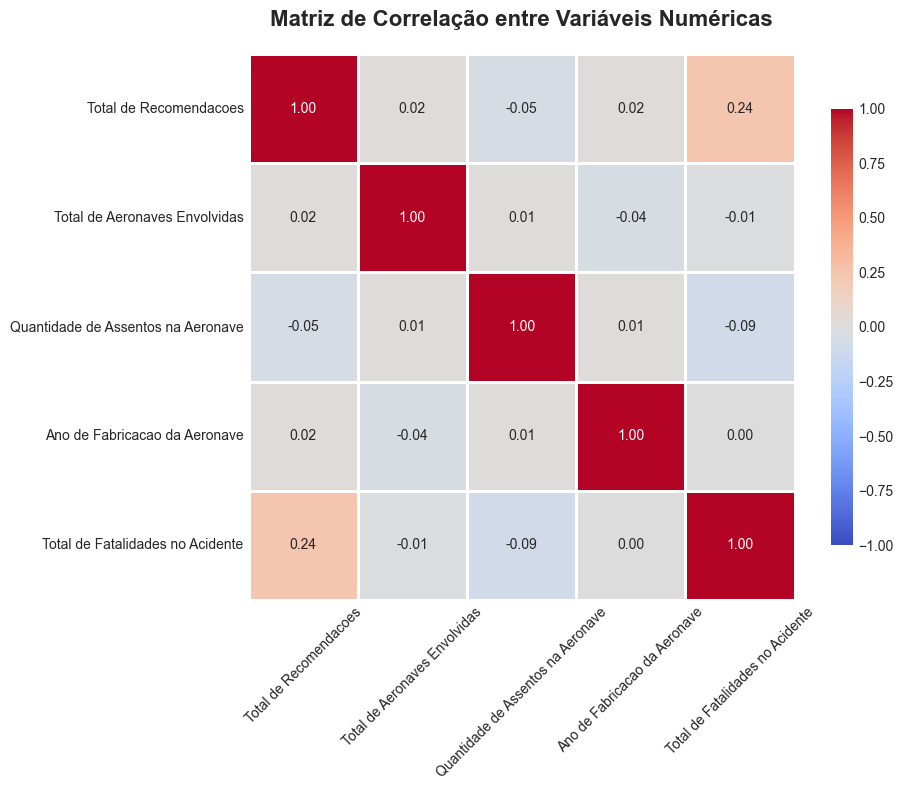

Valores próximos de +1 ou -1 indicam correlação forte.
Valores próximos de 0 indicam pouca ou nenhuma correlação.
                                    Total de Recomendacoes  \
Total de Recomendacoes                            1.000000   
Total de Aeronaves Envolvidas                     0.017344   
Quantidade de Assentos na Aeronave               -0.053921   
Ano de Fabricacao da Aeronave                     0.018431   
Total de Fatalidades no Acidente                  0.238955   

                                    Total de Aeronaves Envolvidas  \
Total de Recomendacoes                                   0.017344   
Total de Aeronaves Envolvidas                            1.000000   
Quantidade de Assentos na Aeronave                       0.014854   
Ano de Fabricacao da Aeronave                           -0.041893   
Total de Fatalidades no Acidente                        -0.009762   

                                    Quantidade de Assentos na Aeronave  \
Total de Recomendacoes  

In [ ]:
# Preparando dados numéricos
colunas_numericas = ['Total de Recomendacoes', 'Total de Aeronaves Envolvidas',
                     'Quantidade de Assentos na Aeronave', 'Ano de Fabricacao da Aeronave',
                     'Total de Fatalidades no Acidente']

df_corr = df.copy()
for col in colunas_numericas:
    if col in df_corr.columns:
        df_corr[col] = pd.to_numeric(df_corr[col], errors='coerce')

colunas_existentes = [col for col in colunas_numericas if col in df_corr.columns]
df_corr_clean = df_corr[colunas_existentes].dropna()

if len(df_corr_clean.columns) > 1:
    matriz_corr = df_corr_clean.corr()
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(matriz_corr, annot=True, fmt='.2f', cmap='coolwarm', center=0,
               square=True, linewidths=1, cbar_kws={"shrink": 0.8},
               vmin=-1, vmax=1)
    plt.title('Matriz de Correlação entre Variáveis Numéricas', fontsize=16, fontweight='bold', pad=20)
    plt.tick_params(axis='x', rotation=45, labelsize=10)
    plt.tick_params(axis='y', rotation=0, labelsize=10)
    plt.tight_layout()
    plt.show()
    
    print("Valores próximos de +1 ou -1 indicam correlação forte.")
    print("Valores próximos de 0 indicam pouca ou nenhuma correlação.")
    print(matriz_corr)
else:
    print("Dados insuficientes para análise de correlação.")
